In [13]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
from preprocessing import *
import matplotlib.pyplot as plt
import json
import PIL

In [ ]:
with open('config.json') as config_buffer:
    config = json.load(config_buffer)

validation_datasets = [{**ds, 'path': os.path.join(config['train']['images_dir'], ds['path'])}
                       for ds in config['train']['validation_datasets']]

trassir_annotation = TrassirRectShapesAnnotations([], validation_datasets, config['model']['labels'], config['model']['skip_labels'])
trassir_annotation.load()
trassir_annotation.print_statistics()
validation = trassir_annotation.get_validation_instances(config['train']['verifiers'], config['model']['max_box_per_image'])
print('Val len: ', len(validation))

In [708]:
image_per_bbs = []
for item in validation:
    image = np.array(PIL.Image.open(item['file_name']))
    h, w, _ = image.shape
    bbs = ia.BoundingBoxesOnImage([
        ia.BoundingBox(x1=bbox['bbox'][0][0] * w, y1=bbox['bbox'][0][1] * h, x2=bbox['bbox'][1][0] * w, y2=bbox['bbox'][1][1] * h, 
                       label=bbox)
        for bbox in item['annotations']
        if bbox['bbox'] != []
    ], shape=image.shape)
    image_per_bbs.append([image, bbs])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


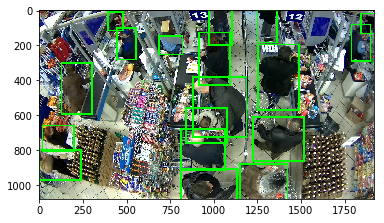

In [745]:
idx = 101

img, bbs = image_per_bbs[idx]

seq = iaa.Sequential(
    [
        iaa.Crop(percent=(0.1, 0.5)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.01),
        iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5)),
        iaa.ContrastNormalization((0.5, 1.5)),
    ])

seq_det = seq.to_deterministic()

img_aug = seq_det.augment_images([img])[0]
bbs_aug = seq_det.augment_bounding_boxes([bbs])[0].remove_out_of_image() 

plt.imshow(bbs.draw_on_image(img, thickness=10))

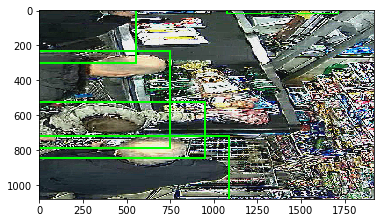

In [746]:
plt.imshow(bbs_aug.draw_on_image(img_aug, thickness=10))

0.5688295448363687
0.9775335646839701
5.320886243307685
4.791046709979218
0.10240108985421298


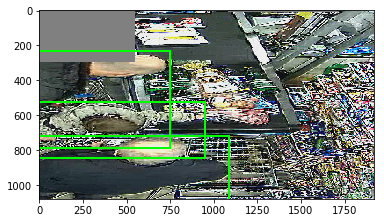

In [747]:
bbs, filtered_bbs = remove_on_the_edge(bbs_aug, img_aug.shape)
fill_filtered_with_gray(img_aug, filtered_bbs)
plt.imshow(bbs.draw_on_image(img_aug, thickness=10))

In [730]:
img_aug.shape

(1080, 1920, 3)

In [731]:
def _is_on_the_edge(bb, w, h):
    return np.isclose(bb.x1, 0.) or np.isclose(bb.x2, 0.) or np.isclose(bb.y1, 0.) or np.isclose(bb.y2, 0.) \
        or np.isclose(bb.x1, w) or np.isclose(bb.x2, w) or np.isclose(bb.y1, h) or np.isclose(bb.y2, h)

def _is_edge_big_diff(bb):
    w = bb.x2 - bb.x1
    h = bb.y2 - bb.y1
    return (max(w, h) / min(w, h)) > 5.

def _is_area_small(bb, w, h, area_limit=10.):
    bb_w = bb.x2 - bb.x1
    bb_h = bb.y2 - bb.y1
    return np.sqrt((w * h) / (bb_w * bb_h)) > area_limit

def _is_area_out_of_image_large(bb, w, h, max_area_ratio=0.7):
    top_bb_area = max(0., (bb.x2 - bb.x1) * (0. - bb.y1))
    left_bb_area = max(0., (0. - bb.x1) * (bb.y2 - bb.y1))
    right_bb_area = max(0., (bb.x2 - w) * (bb.y2 - bb.y1))
    down_bb_area = max(0., (bb.x2 - bb.x1) * (bb.y2 - h))

    cutten_box_area = (min(bb.x2, w) - max(bb.x1, 0.)) * (min(bb.y2, h) - max(bb.y1, 0.))
    print(cutten_box_area / (top_bb_area + left_bb_area + right_bb_area + down_bb_area + np.finfo(np.float).eps))

    return cutten_box_area / (top_bb_area + left_bb_area + right_bb_area + down_bb_area + np.finfo(np.float).eps) < max_area_ratio

def fill_filtered_with_gray(img, bbs):
    h, w, _ = img.shape
    for bb in bbs.bounding_boxes:
        img[int(max(bb.y1, 0)):int(min(bb.y2, h)), int(max(bb.x1, 0)):int(min(bb.x2, w))] = 128
    
def remove_on_the_edge(bbs, image_shape):
    h, w, _ = image_shape
    
    filtered = []
    
    tmp_bbs = []
    for bb in bbs.bounding_boxes:
        if not _is_area_out_of_image_large(bb, w, h):
            tmp_bbs.append(bb)
        else:
            filtered.append(bb)
    
    final_bbs = []
    for bb in ia.BoundingBoxesOnImage(tmp_bbs, shape=image_shape).cut_out_of_image().bounding_boxes:
        if not ((_is_on_the_edge(bb, w, h) and _is_edge_big_diff(bb)) \
            or (_is_on_the_edge(bb, w, h) and _is_area_small(bb, w, h))):
            final_bbs.append(bb)
        else:
            filtered.append(bb)
            
    return ia.BoundingBoxesOnImage(final_bbs, shape=image_shape), \
        ia.BoundingBoxesOnImage(filtered, shape=image_shape).cut_out_of_image()

In [496]:
a = bbs.bounding_boxes[0]

In [497]:
a.area

24366.729351563787